# Imports

In [100]:
import numpy as np
import matplotlib.pyplot as plt

import json # original json library

import pandas as pd
import logging

from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

import sklearn
import shap

## Log set-up

In [101]:
LOG_FILENAME = '/home/benjamin/Folders_Python/Cyber/logs/logfile.log'
LOG_FORMAT = '%(asctime)% -- %(name)s -- %(levelname)s -- %(message)s'
# LOG_LEVEL = logging.INFO

In [102]:
# specific logger for the module
logger = logging.getLogger(__name__)   # creates specific logger for the module
logger.setLevel(logging.DEBUG)    # entry level of messages from all handlers
LOG_FORMAT = '%(asctime)s -- %(name)s -- %(levelname)s -- %(message)s'
formatter = logging.Formatter(LOG_FORMAT)

# file handler to log everything
file_handler = logging.FileHandler(LOG_FILENAME, mode='w')
file_handler.setLevel(logging.INFO)  # all messages (DEBUG and up) get logged in the file
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# stream handler to show messages to the console
console = logging.StreamHandler()
console.setLevel(logging.WARNING)  # Warning messages and up get displayed to the console
console.setFormatter(formatter)
logger.addHandler(console)

# start your engine
logger.info("-------- new run --------")

# Import pcap file

In [103]:
# NB : tshark -r <file>.pcap -T json > <file_pcap>.json -t r
# commande shell qui prend un pcap et le passe en json

!rm /home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json
# !tshark -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/input.pcap -T json -t r > /home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json

#------------------------------------------------------------------------------------------------------------
#-- NB : On passe par le JSON depuis le pcap pour parser les paquets et créer la df 'raw packets' 
#-- A RE ECRIRE CAR ABSOLUMENT PAS OPTIMAL !!  UTILISER pyshark
#------------------------------------------------------------------------------------------------------------

# logger.info("run tshark to create json translation of input.pcap")

rm: cannot remove '/home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json': No such file or directory


In [104]:
class Packet():
    """Utility self-made unperfect class to parse the json object and extract features from a packet-like dict
    """
    
    def __init__(self, raw_packet:dict) -> None:
        self.raw_packet = raw_packet
        self._packet_data = None
        # logger.debug('constructor of Packet instance has finished')
        
    @property
    def packet_data(self):
        # returns the full dictionnary of features
        if self._packet_data is not None:
            return self._packet_data
        else:
            sl = self.raw_packet.get('_source').get('layers')
            slf = sl.get('frame')
            sle = sl.get('eth')
            sli = sl.get('ip', {})  # return empty dict as default not found value so it can handle another get method
            slu = sl.get('udp', {})
            slt = sl.get('tcp', {})
                                               
            self._packet_data = {
                'frame_time' : slf.get('frame.time'),
                'frame_time_relative' : slf.get('frame.time_relative'),
                'frame_length' : slf.get("frame.len"),
                'frame_protocols' : slf.get("frame.protocols"),
                'eth_source': sle.get("eth.src"),
                'eth_dest': sle.get("eth.dst") ,
                'ip_version': sli.get("ip.version"),
                'ip_header_length': sli.get("ip.hdr_len"),
                'ip_length': sli.get("ip.len"),
                'ip_id': sli.get("ip.id"),
                'ip_flags': sli.get("ip.flags"),
                'ip_ttl': sli.get("ip.ttl"),
                'ip_proto': sli.get("ip.proto"),
                'ip_source': sli.get("ip.src"),
                'ip_dest': sli.get("ip.dst"),
                'udp_source_port': slu.get("udp.srcport"),
                'udp_dest_port': slu.get("udp.port"),
                'udp_length': slu.get("udp.length"),
                'tcp_source_port': slt.get("tcp.srcport"),
                'tcp_dest_port': slt.get("tcp.dstport"),
                'tcp_length': slt.get("tcp.len"),
                'tcp_flags': slt.get("tcp.flags"),
            }
            # logger.debug('packet_data @property method has finished')
            return self._packet_data
        
    @packet_data.setter
    def packet_data(self, input):
        """illegal attempt to write packet_data"""
        logger.warning('Illegal attempt to write a data_packet in a packet object')
        pass

In [105]:
# PCAP_FILENAME = "/home/benjamin/Folders_Python/Cyber/data/outputs/input_pcap.json"

# with open (PCAP_FILENAME, errors='replace') as raw_packets:  # NB : errors='replace' bypasses decoding errors
#     json_object = json.load(raw_packets)    # load le fichier json dans une structure Python (list of dicts)

In [106]:
# Exemple : premier dict de la liste : c'est un paquet (=une frame Ethernet)

# json_object[0]

In [107]:
# exemple d'instanciation d'un objet Packet
# p = Packet(json_object[0])

# p.packet_data

# Produce DataFrame for Raw Packets analysis

In [108]:
# créé la liste de dictionnaires des data des objets Packets
# packets = [ Packet(d).packet_data for d in json_object ]

# df_packets = pd.DataFrame(packets)

# df_packets

In [109]:
# df_packets.describe(include='all').transpose()

# EVE JSON Output by Suricata

In [110]:
# run Suricata to produce an eve.json file with alerts

!rm /home/benjamin/Folders_Python/Cyber/data/outputs/eve.json
!suricata -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/input.pcap -l /home/benjamin/Folders_Python/Cyber/data/outputs -k none
# !suricata -r /home/benjamin/Folders_Python/Cyber/data/input_pcaps/bigFlows.pcap -l /home/benjamin/Folders_Python/Cyber/data/outputs -k none

logger.info("run Suricata to reassemble flows and create alert logs")

25/6/2023 -- 13:23:47 - <Info> - Configuration node 'af-packet' redefined.
25/6/2023 -- 13:23:47 - <Notice> - This is Suricata version 6.0.1 RELEASE running in USER mode
25/6/2023 -- 13:24:49 - <Warning> - [ERRCODE: SC_ERR_INITIALIZATION(45)] - Unix socket: UNIX socket bind(/var/run/suricata-command.socket) error: Address already in use
25/6/2023 -- 13:24:49 - <Warning> - [ERRCODE: SC_ERR_INITIALIZATION(45)] - Unable to create unix command socket
25/6/2023 -- 13:24:49 - <Notice> - all 5 packet processing threads, 4 management threads initialized, engine started.
25/6/2023 -- 13:25:04 - <Notice> - Signal Received.  Stopping engine.
25/6/2023 -- 13:25:05 - <Notice> - Pcap-file module read 1 files, 791615 packets, 355417784 bytes


In [111]:
# Pandas provides a useful method – json_normalize – for normalizing nested JSON fields into dataframe. Resulting columns use dot notation to signify nested objects, similar to how Elasticsearch does it

SURICATA_EVE_LOG = "/home/benjamin/Folders_Python/Cyber/data/outputs/eve.json"

with open (SURICATA_EVE_LOG) as packets:
    df_log = pd.json_normalize(
        [json.loads(packet) for packet in packets],
        max_level=1
    )

In [112]:
df_log

,timestamp,flow_id,pcap_cnt,event_type,src_ip,src_port,dest_ip,dest_port,proto,community_id,...,ftp.reply_received,ftp.command,ftp.command_data,http.content_range,fileinfo.start,fileinfo.end,ftp.completion_code,tcp.cwr,response_icmp_type,response_icmp_code
0,2013-02-26T23:02:36.058887+0100,2.528584e+14,194.0,dns,172.16.133.6,63229.0,8.8.8.8,53.0,UDP,1:AyH5HOOHZJPTvlg9DZtiTQwszaY=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-26T23:02:36.190384+0100,1.271249e+15,503.0,http,172.16.133.132,38625.0,98.139.134.187,80.0,TCP,1:HNTVc848Qvp5IEiaQ5Iz1ELivII=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-02-26T23:02:36.190384+0100,1.271249e+15,503.0,fileinfo,98.139.134.187,80.0,172.16.133.132,38625.0,TCP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-02-26T23:02:36.303034+0100,1.372546e+15,832.0,snmp,172.16.128.169,3499.0,172.16.133.248,161.0,UDP,1:Oy17/E89UzuoKqKVAQzWppdhr5o=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-02-26T23:02:36.308732+0100,1.372546e+15,856.0,snmp,172.16.133.248,161.0,172.16.128.169,3499.0,UDP,1:Oy17/E89UzuoKqKVAQzWppdhr5o=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49887,2013-02-26T23:07:35.949374+0100,2.111022e+15,NaN,flow,172.16.133.109,45061.0,172.16.128.202,53.0,UDP,1:HQ5FPLO2rb6gj+cZyRVIvRAIAcQ=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49888,2013-02-26T23:07:35.949374+0100,1.125881e+15,NaN,flow,172.16.133.6,52492.0,8.8.8.8,53.0,UDP,1:0JVSAAqDWDClLKSBpGtGEBwdrVg=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49889,2013-02-26T23:07:35.949374+0100,1.548102e+15,NaN,flow,172.16.133.84,59018.0,172.16.139.250,5440.0,TCP,1:JpN9B8+N4+B3euTVc1T+SCuK++c=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49890,2013-02-26T23:07:35.949374+0100,8.444215e+14,NaN,flow,172.16.133.55,57815.0,172.16.139.250,5440.0,TCP,1:2WvVapwewfrHiOaBoTbEdrpYnx8=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
df_log[df_log['event_type']=='flow']

,timestamp,flow_id,pcap_cnt,event_type,src_ip,src_port,dest_ip,dest_port,proto,community_id,...,ftp.reply_received,ftp.command,ftp.command_data,http.content_range,fileinfo.start,fileinfo.end,ftp.completion_code,tcp.cwr,response_icmp_type,response_icmp_code
2963,2013-02-26T23:02:35.953172+0100,4.348555e+14,NaN,flow,fe80:0000:0000:0000:3d1c:9cea:dce1:314b,546.0,ff02:0000:0000:0000:0000:0000:0001:0002,547.0,UDP,1:MNDRNanH5svj7m9KcGwa4vmJmLg=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3139,2013-02-26T23:02:35.953172+0100,7.774049e+14,NaN,flow,172.16.133.109,49151.0,4.69.148.254,49557.0,UDP,1:lXCR/W1cOEcfrBEZyIUrjiLPY7U=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3522,2013-02-26T23:02:35.953172+0100,1.153273e+15,NaN,flow,fe80:0000:0000:0000:dc71:28ef:84cb:87dc,546.0,ff02:0000:0000:0000:0000:0000:0001:0002,547.0,UDP,1:GneeyT+giCVzwJxseNu6rV68sEE=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3580,2013-02-26T23:02:35.953172+0100,4.061308e+14,NaN,flow,172.16.133.23,52853.0,239.255.255.250,1900.0,UDP,1:dOzPUwaa/YONpkEzHUWDQJrB3so=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3730,2013-02-26T23:02:35.953172+0100,1.654626e+15,NaN,flow,172.16.133.36,62066.0,172.16.133.1,192.0,UDP,1:/lctjosgadpBHqovsxo1Iy8yCj8=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49886,2013-02-26T23:07:35.949374+0100,2.814200e+14,NaN,flow,172.16.133.29,61113.0,23.0.49.244,80.0,TCP,1:QI/zN48KMMOaKGHOJIkvoQscBQw=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49887,2013-02-26T23:07:35.949374+0100,2.111022e+15,NaN,flow,172.16.133.109,45061.0,172.16.128.202,53.0,UDP,1:HQ5FPLO2rb6gj+cZyRVIvRAIAcQ=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49888,2013-02-26T23:07:35.949374+0100,1.125881e+15,NaN,flow,172.16.133.6,52492.0,8.8.8.8,53.0,UDP,1:0JVSAAqDWDClLKSBpGtGEBwdrVg=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49889,2013-02-26T23:07:35.949374+0100,1.548102e+15,NaN,flow,172.16.133.84,59018.0,172.16.139.250,5440.0,TCP,1:JpN9B8+N4+B3euTVc1T+SCuK++c=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Produce DataFrame for Flow Analysis

In [114]:
# from Suricata doc :

# 15.1.2.12. Event type: Flow
# 15.1.2.12.1. Fields

#     “pkts_toserver”: total number of packets to server, include bypassed packets
#     “pkts_toclient”: total number of packets to client
#     “bytes_toserver”: total bytes count to server
#     “bytes_toclient”: total bytes count to client
#     “bypassed.pkts_toserver”: number of bypassed packets to server
#     “bypassed.pkts_toclient”: number of bypassed packets to client
#     “bypassed.bytes_toserver”: bypassed bytes count to server
#     “bypassed.bytes_toclient”: bypassed bytes count to client
#     “start”: date of start of the flow
#     “end”: date of end of flow (last seen packet)
#     “age”: duration of the flow
#     “bypass”: if the flow has been bypassed, it is set to “local” (internal bypass) or “capture”
#     “state”: display state of the flow (include “new”, “established”, “closed”, “bypassed”)
#     “reason”: mechanism that did trigger the end of the flow (include “timeout”, “forced” and “shutdown”)
#     “alerted”: “true” or “false” depending if an alert has been seen on flow

In [115]:
# https://www.stamus-networks.com/blog/jupyter-playbooks-for-suricata-part-1

# https://malware-traffic-analysis.net/

In [116]:
class Flow():
    """Utility class - takes a event-flow string out of eve.json,
       creates a one-level dict structure, suitable for dataframe creation
    """
    def __init__(self, flow_event:dict):
        if flow_event.get('event_type') != 'flow':
            logger.critical("Attempt to build a Flow instance with a non-flow event")
            raise ValueError
        self._raw_flow_event = flow_event
        self._features = None
        
    @property
    def features(self):
        if self._features is not None:
            return self._features
        else:
            keys_list_first_level = [
                'timestamp',
                'flow_id',
                'src_ip',
                'src_port',
                'dest_ip',
                'dest_port',
                'proto'
            ]
            keys_list_second_level = [
                'pkts_toserver',
                'pkts_toclient',
                'bytes_toserver',
                'bytes_toclient',
                'start',
                'end',
                'age',
                'state',
                'reason',
                'alerted'
            ]
            d1 = { k: self._raw_flow_event.get(k) for k in keys_list_first_level }
            d2 = { k: self._raw_flow_event.get('flow').get(k) for k in keys_list_second_level }
            self._features = { **d1, **d2 }
            # logger.info("built a Flow features object")
            return self._features
        
    @features.setter
    def features(self, input):
        logger.critical("illegal attempt to hard write features in a Flow object")
        
    def __str__(self) -> str:
        return json.dumps(self.features, indent=4)
    
    def __repr__(self) -> str:
        return json.dumps(self.features, indent=4)


In [117]:
# exemple de flow JSON = 
# {
# "timestamp":"2023-06-17T10:46:05.765744+0200",
# "flow_id":860724109937755,
# "event_type":"flow",
# "src_ip":"2a01:cb19:872e:3000:0e4f:3187:540c:d66c",
# "src_port":47864,
# "dest_ip":"2a00:1450:4007:081a:0000:0000:0000:2003",
# "dest_port":80,
# "proto":"TCP",
# "flow":
#     {"pkts_toserver":6,
#     "pkts_toclient":5,
#     "bytes_toserver":516,
#     "bytes_toclient":430,
#     "start":"2023-06-17T10:46:10.625755+0200",
#     "end":"2023-06-17T10:46:44.150502+0200",
#     "age":34,
#     "state":"new",
#     "reason":"shutdown",
#     "alerted":true},
# "community_id":"1:uRhWV544zvWeIohZCmryZHXZ5EA=",
# "tcp":
#     {"tcp_flags":"00",
#     "tcp_flags_ts":"00",
#     "tcp_flags_tc":"00"
#     }
# }'

In [118]:
SURICATA_EVE_LOG = "/home/benjamin/Folders_Python/Cyber/data/outputs/eve.json"

i=0
columns_names =  [
                'timestamp',
                'flow_id',
                'src_ip',
                'src_port',
                'dest_ip',
                'dest_port',
                'proto'
            ] + [
                'pkts_toserver',
                'pkts_toclient',
                'bytes_toserver',
                'bytes_toclient',
                'start',
                'end',
                'age',
                'state',
                'reason',
                'alerted'
            ]
dict_for_dataframe = { k:[] for k in columns_names }

with open (SURICATA_EVE_LOG) as f:
    for event_string in f:
        python_object = json.loads(event_string)
        if python_object.get('event_type')=='flow':
            flow = Flow(python_object)
            for k in columns_names:
                if dict_for_dataframe[k] == []:
                    dict_for_dataframe[k] = [flow.features.get(k)]
                else:
                    dict_for_dataframe[k].append(flow.features.get(k))

In [119]:
df_flow = pd.DataFrame(data=dict_for_dataframe)

In [120]:
df_flow

,timestamp,flow_id,src_ip,src_port,dest_ip,dest_port,proto,pkts_toserver,pkts_toclient,bytes_toserver,bytes_toclient,start,end,age,state,reason,alerted
0,2013-02-26T23:02:35.953172+0100,434855523571788,fe80:0000:0000:0000:3d1c:9cea:dce1:314b,546.0,ff02:0000:0000:0000:0000:0000:0001:0002,547.0,UDP,1,0,160,0,2013-02-26T23:02:42.907340+0100,2013-02-26T23:02:42.907340+0100,0,new,timeout,False
1,2013-02-26T23:02:35.953172+0100,777404935432195,172.16.133.109,49151.0,4.69.148.254,49557.0,UDP,1,0,78,0,2013-02-26T23:02:45.583683+0100,2013-02-26T23:02:45.583683+0100,0,new,timeout,False
2,2013-02-26T23:02:35.953172+0100,1153272556072516,fe80:0000:0000:0000:dc71:28ef:84cb:87dc,546.0,ff02:0000:0000:0000:0000:0000:0001:0002,547.0,UDP,1,0,160,0,2013-02-26T23:02:48.044612+0100,2013-02-26T23:02:48.044612+0100,0,new,timeout,False
3,2013-02-26T23:02:35.953172+0100,406130781917747,172.16.133.23,52853.0,239.255.255.250,1900.0,UDP,2,0,350,0,2013-02-26T23:02:37.987699+0100,2013-02-26T23:02:40.987684+0100,3,new,timeout,False
4,2013-02-26T23:02:35.953172+0100,1654626236693771,172.16.133.36,62066.0,172.16.133.1,192.0,UDP,1,0,60,0,2013-02-26T23:02:58.916747+0100,2013-02-26T23:02:58.916747+0100,0,new,timeout,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28029,2013-02-26T23:07:35.949374+0100,281419976343451,172.16.133.29,61113.0,23.0.49.244,80.0,TCP,4,2,246,126,2013-02-26T23:05:44.720795+0100,2013-02-26T23:05:57.056373+0100,13,closed,shutdown,False
28030,2013-02-26T23:07:35.949374+0100,2111022350493961,172.16.133.109,45061.0,172.16.128.202,53.0,UDP,2,1,198,85,2013-02-26T23:04:00.289033+0100,2013-02-26T23:04:12.289822+0100,12,established,shutdown,False
28031,2013-02-26T23:07:35.949374+0100,1125881408051661,172.16.133.6,52492.0,8.8.8.8,53.0,UDP,1,1,82,98,2013-02-26T23:04:18.907725+0100,2013-02-26T23:04:18.934087+0100,0,established,shutdown,False
28032,2013-02-26T23:07:35.949374+0100,1548102473514109,172.16.133.84,59018.0,172.16.139.250,5440.0,TCP,10,0,1022,0,2013-02-26T23:06:58.752765+0100,2013-02-26T23:06:58.758302+0100,0,new,shutdown,False


# Some Machine Learning

In [121]:
df_flow.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
timestamp,28034,4730,2013-02-26T23:07:35.949374+0100,19188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flow_id,28034.0,NaN,NaN,NaN,1121487926568005.875,649399716812137.125,106056274902.0,558793253539633.0,1115737765056779.0,1687007606860975.0,2251650325488146.0
src_ip,28034,389,172.16.128.169,1359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_port,27824.0,NaN,NaN,NaN,51850.32073,16114.658983,22.0,52386.75,56118.5,60580.0,65534.0
dest_ip,28034,1651,172.16.139.250,13184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dest_port,27824.0,NaN,NaN,NaN,6746.316238,13557.475365,7.0,161.0,5440.0,5440.0,65531.0
proto,28034,4,TCP,22569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pkts_toserver,28034.0,NaN,NaN,NaN,17.311657,212.799352,1.0,4.0,10.0,12.0,25733.0
pkts_toclient,28034.0,NaN,NaN,NaN,10.872548,157.336968,0.0,0.0,0.0,2.0,14980.0
bytes_toserver,28034.0,NaN,NaN,NaN,5677.227652,183705.4693,60.0,246.0,1022.0,1142.0,17342134.0


In [122]:
df_flow.dtypes

timestamp          object
flow_id             int64
src_ip             object
src_port          float64
dest_ip            object
dest_port         float64
proto              object
pkts_toserver       int64
pkts_toclient       int64
bytes_toserver      int64
bytes_toclient      int64
start              object
end                object
age                 int64
state              object
reason             object
alerted              bool
dtype: object

In [123]:
df = df_flow.copy(deep=True)

In [124]:
# codage en ordinal

df['src_ip_ord'], uniques_src_ip = pd.factorize(values=df['src_ip'])
df['dest_ip_ord'], uniques_dest_ip = pd.factorize(values=df['dest_ip'])
df['proto_ord'], uniques_proto = pd.factorize(values=df['proto'])

In [125]:
# Flows flagged as 'alerted' by Suricata

df[df['alerted']==True]

,timestamp,flow_id,src_ip,src_port,dest_ip,dest_port,proto,pkts_toserver,pkts_toclient,bytes_toserver,bytes_toclient,start,end,age,state,reason,alerted,src_ip_ord,dest_ip_ord,proto_ord
752,2013-02-26T23:04:17.620505+0100,622717395326168,172.16.133.113,55604.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:03:16.251096+0100,2013-02-26T23:03:16.756528+0100,0,new,unknown,True,73,16,1
851,2013-02-26T23:04:22.356835+0100,906951886839978,172.16.133.78,59049.0,8.27.243.253,80.0,TCP,5,4,306,1083,2013-02-26T23:02:51.663722+0100,2013-02-26T23:03:11.020292+0100,20,closed,timeout,True,43,155,1
1032,2013-02-26T23:04:26.013558+0100,836196595320170,172.16.133.28,65291.0,208.111.161.254,80.0,TCP,22,34,3070,41794,2013-02-26T23:02:46.050538+0100,2013-02-26T23:03:25.617068+0100,39,closed,timeout,True,75,128,1
1165,2013-02-26T23:04:31.375659+0100,1193376813324817,172.16.133.16,59330.0,208.85.42.33,80.0,TCP,643,1236,41114,1865875,2013-02-26T23:02:50.498193+0100,2013-02-26T23:02:52.655689+0100,2,closed,timeout,True,128,246,1
1228,2013-02-26T23:04:33.550043+0100,1194547191857010,172.16.133.113,55590.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:02:49.049010+0100,2013-02-26T23:02:49.556803+0100,0,new,unknown,True,73,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25829,2013-02-26T23:07:35.949374+0100,961644017759413,172.16.133.113,55769.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:07:16.734389+0100,2013-02-26T23:07:17.294760+0100,1,new,shutdown,True,73,16,1
26007,2013-02-26T23:07:35.949374+0100,118788889312297,172.16.133.113,55653.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:05:00.457769+0100,2013-02-26T23:05:00.980789+0100,0,new,shutdown,True,73,16,1
26074,2013-02-26T23:07:35.949374+0100,1526904664855929,172.16.133.113,55786.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:07:35.038265+0100,2013-02-26T23:07:35.553658+0100,0,new,shutdown,True,73,16,1
26213,2013-02-26T23:07:35.949374+0100,1809831334498295,172.16.133.113,55693.0,172.16.139.250,5462.0,TCP,10,0,696,0,2013-02-26T23:06:03.905207+0100,2013-02-26T23:06:04.421371+0100,1,new,shutdown,True,73,16,1


### PCA

In [126]:
columns_names = ['src_port', 'dest_port', 'pkts_toserver', 'pkts_toclient', 'bytes_toserver', 'bytes_toclient', 'age', 'src_ip_ord', 'dest_ip_ord', 'proto_ord', 'alerted']
features_names = ['src_port', 'dest_port', 'pkts_toserver', 'pkts_toclient', 'bytes_toserver', 'bytes_toclient', 'age', 'src_ip_ord', 'dest_ip_ord', 'proto_ord']

df_clean = df[columns_names].dropna()

X = df_clean[features_names].to_numpy()
y = df_clean['alerted'].to_numpy()

In [127]:
pca = PCA(n_components=3)  # scikit learn trick : when 0 < n_components < 1, choose the number of components so that the explained variance is above 90%

X_new = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

[0.67840028 0.31286237 0.00562021]


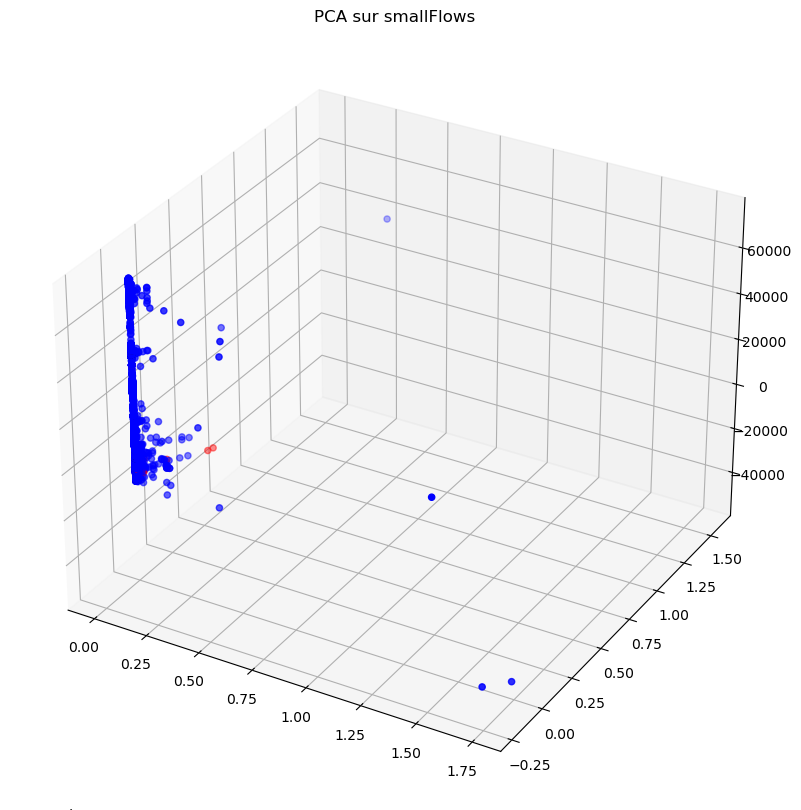

In [128]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

xs = X_new[:,0]
ys = X_new[:,1]
zs = X_new[:,2]

colors = [ 'red' if c == True else 'blue' for c in list(y)]

ax.scatter3D(xs, ys, zs, c=colors)
ax.set_title("PCA sur smallFlows")
plt.show()

### Classifiers

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [130]:
# X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.5, random_state=42)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)
train_idx, test_idx = next(sss.split(X, y))
X_train = X[train_idx]
X_test =X[test_idx]
Y_train = y[train_idx]
Y_test = y[test_idx]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [131]:
# Vérification du split

n_pos_full = len(df[df["alerted"]==True])
n_neg_full = len(df[df["alerted"]==False])

print(f"Full dataset : there are {n_pos_full} alerts, and {n_neg_full} benign, ie {n_pos_full/(n_pos_full+n_neg_full)*100:.2f}%")

n_pos_train = np.sum(Y_train)
n_neg_train = len(Y_train) - n_pos_train
print(f"Training dataset : {n_pos_train} pos, {len(Y_train)} total, {n_pos_train/(n_neg_train+n_pos_train)*100:.2f}%")

n_pos_test = np.sum(Y_test)
n_neg_test = len(Y_test) - n_pos_test
print(f"Test dataset : {n_pos_test} pos, {len(Y_test)} total, {n_pos_test/(n_neg_test+n_pos_test)*100:.2f}%")

Full dataset : there are 108 alerts, and 27926 benign, ie 0.39%
Training dataset : 11 pos, 2782 total, 0.40%
Test dataset : 97 pos, 25042 total, 0.39%


### A couple of classifiers : Logistic Regression, SVM Linear, Random Forest

In [132]:
clf_lr = sklearn.linear_model.LogisticRegression(random_state=42, max_iter=1000)
clf_lr.fit(X_train, Y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [133]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability=True)
clf_svm.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [134]:
clf_rf = sklearn.ensemble.RandomForestClassifier()
clf_rf.fit(X_train, Y_train)

RandomForestClassifier()

In [135]:
models = {
    "Logistic_Regression" : clf_lr,
    "SVM_linear_kernel" : clf_svm,
    "Random_Forest" : clf_rf
}

In [136]:
roc_curve_params = {}

Accuracy of Logistic_Regression = 99.61%


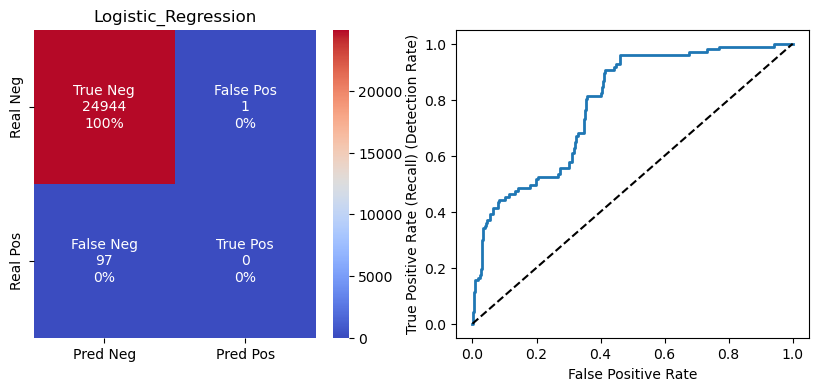

Accuracy of SVM_linear_kernel = 99.60%


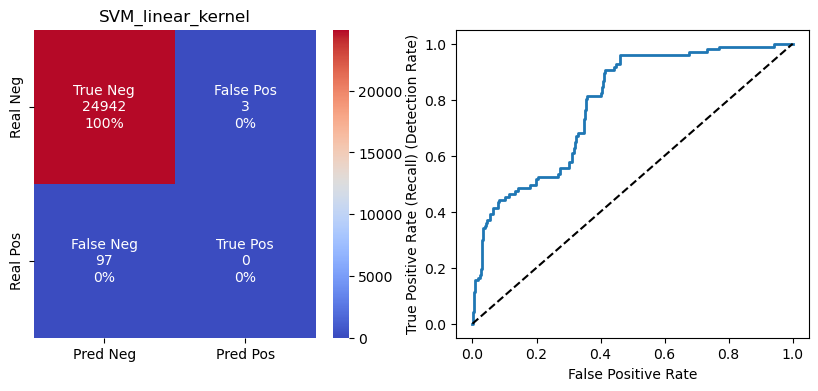

Accuracy of Random_Forest = 99.74%


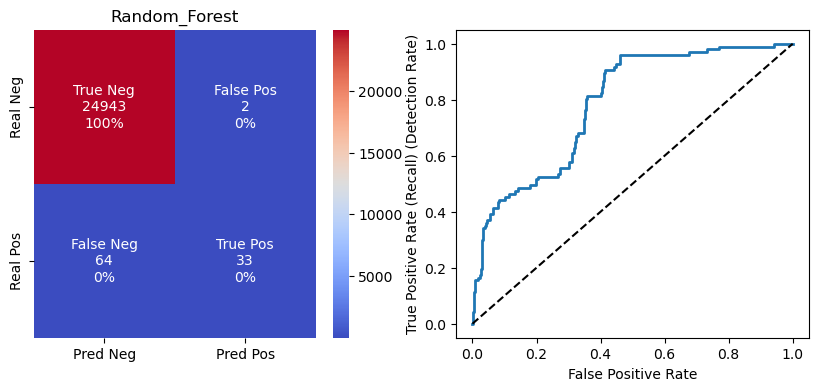

In [137]:
for name, model in models.items():
    print(f"Accuracy of {name} = {model.score(X_test, Y_test)*100:.2f}%")

    Y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(Y_test, Y_pred)

    # print(cf_matrix)

    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = [ f'{value:0}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value*100:.0f}%' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [ f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages) ]
    labels = np.asarray(labels).reshape(2,2)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="coolwarm", center = np.sum(cf_matrix)/2, xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["Real Neg", "Real Pos"], ax=ax[0])
    ax[0].set_title(name)

    Y_scores = cross_val_predict(clf_lr, X_test, Y_test, cv=3, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(Y_test, Y_scores[:,1])
    
    roc_curve_params[name] = [ fpr, tpr, thresholds ]

    # fig, ax = plt.subplots()

    ax[1].plot(fpr, tpr, linewidth=2)
    ax[1].plot([0,1], [0,1], 'k--')
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate (Recall) (Detection Rate)")
    plt.show()

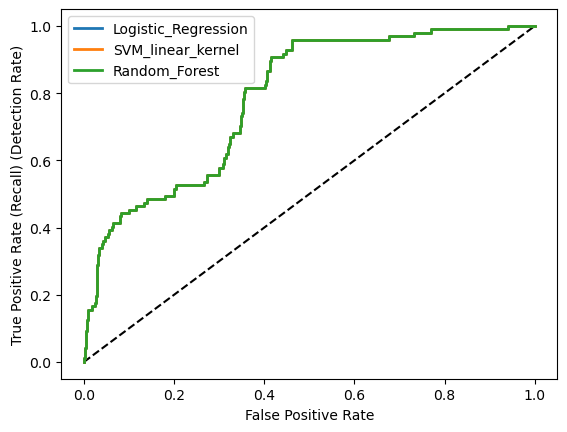

In [138]:
fig, ax = plt.subplots()
    
ax.plot([0,1], [0,1], 'k--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate (Recall) (Detection Rate)")
    
for name, list_params in roc_curve_params.items():
    ax.plot(list_params[0], list_params[1], linewidth=2, label=name)

ax.legend()  
plt.show()

## Explainability

### PCA

In [139]:
# expression of the eigen vectors in the features space

pca.components_

array([[-2.12222773e-03,  1.80286679e-03,  1.04226003e-03,
         6.18626682e-04,  9.88653292e-01,  1.50184694e-01,
         3.34202828e-05,  1.04232818e-05,  4.48871711e-05,
         5.43967645e-09],
       [-1.72106976e-03,  2.42033723e-04,  2.26307192e-04,
         6.91868055e-04, -1.50189826e-01,  9.88655366e-01,
         3.92440999e-05,  1.06670358e-05,  1.77337795e-04,
         5.81486471e-08],
       [-8.93374000e-01,  4.49246526e-01,  9.16737446e-05,
         1.27396749e-04, -2.42823418e-03, -2.03545636e-03,
         2.44521706e-04,  3.87355484e-05,  7.09434024e-03,
        -1.09470413e-05]])

### SHAP

In [140]:
shap.initjs()

explainer = shap.KernelExplainer(clf_rf.predict_proba, X_test[:100])
shap_values = explainer.shap_values(X_test[:100])
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

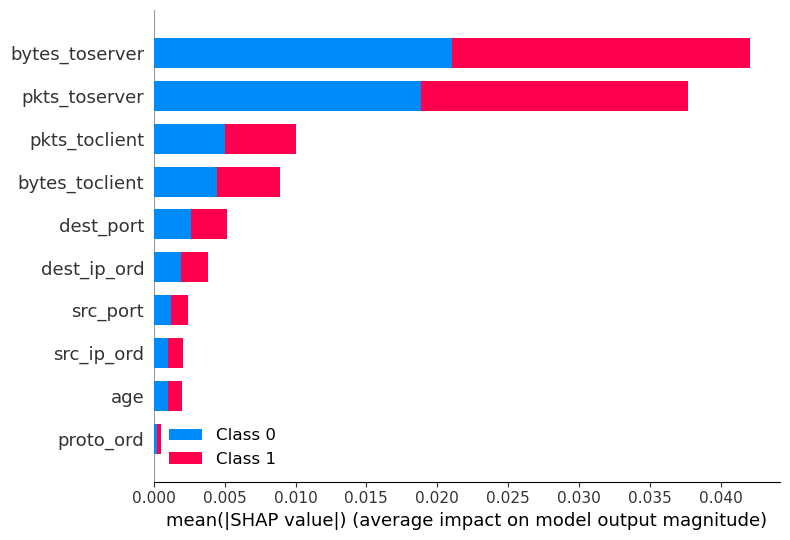

In [141]:
shap.summary_plot(shap_values, X_test, feature_names=features_names)